In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import itertools
from tqdm import tqdm
from kneed import KneeLocator
import seaborn as sns

In [2]:
tr_dm = pd.read_excel('GENERIC BOND PRICE.xlsx', sheet_name='DM_PRICE')
tr_em = pd.read_excel('GENERIC BOND PRICE.xlsx', sheet_name='EM')

tr_dm.Dates = pd.to_datetime(tr_dm.Dates)
tr_em.Dates = pd.to_datetime(tr_em.Dates)
tr_dm = tr_dm.set_index('Dates')
tr_em = tr_em.set_index('Dates')

### Adjust the bond prices to mitigate the impact of the benchmark bond roll.

In [3]:

for bond_col in tr_dm.columns:
    if bond_col.endswith('Govt'): 
        coupon_col = bond_col.replace('Govt', 'Govt CPN')

        tr_dm[f"{bond_col} Adjusted"] = tr_dm[bond_col]
        
        coupon_changes = tr_dm[coupon_col].diff().fillna(0) != 0

        for change_date in tr_dm.index[coupon_changes]:

            price_on_change = tr_dm.loc[change_date, bond_col]
            
            previous_price = tr_dm.loc[tr_dm.index[tr_dm.index.get_loc(change_date) - 1], bond_col]
            
            price_diff = price_on_change - previous_price
            
            tr_dm.loc[change_date:, f"{bond_col} Adjusted"] -= price_diff

        tr_dm[f"{bond_col} Adjusted Return"] = tr_dm[f"{bond_col} Adjusted"].pct_change()


col_adj = [i for i in tr_dm.columns if (i.endswith('Adjusted') or i.endswith('Adjusted Return'))]

col_adj_price = [i for i in tr_dm.columns if i.endswith('Adjusted')]

col_adj_return = [i for i in tr_dm.columns if i.endswith('Adjusted Return')]

tr_dm_net = tr_dm[col_adj].fillna(0)


In [4]:
# Split the data before 2019
tr_dm_before_2019 = tr_dm_net[tr_dm_net.index < '2019-01-01']

# Split the data after (and including) 2019
tr_dm_after_2019 = tr_dm_net[tr_dm_net.index >= '2019-01-01']


## Developed Market Govt Bond Data

<Figure size 1200x600 with 0 Axes>

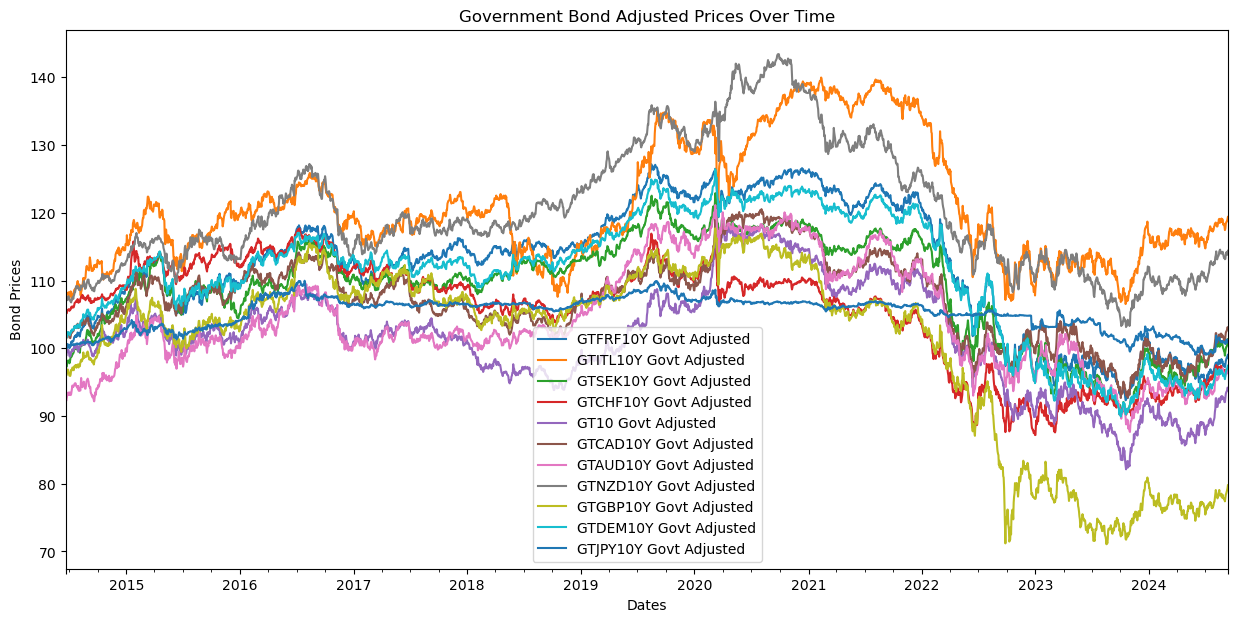

In [5]:
# Plot all the bond adjusted prices to observe their trends
plt.figure(figsize=(12, 6))
tr_dm_net[col_adj_price].plot(title="Government Bond Adjusted Prices Over Time", figsize=(15,7))
plt.ylabel('Bond Prices')
plt.xlabel('Dates')
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.05  

price = tr_dm_net[col_adj_price].pct_change()

jumps = price.abs() > threshold

print("Significant jumps in bond yields (change > 5%):")
for column in tr_dm_net[col_adj_price].columns:
    jumps_in_column = tr_dm_net[col_adj_price][jumps[column]][[column]]
    if not jumps_in_column.empty:
        print(f"\nJumps in {column}:")
        print(jumps_in_column)



Significant jumps in bond yields (change > 5%):

Jumps in GTGBP10Y Govt Adjusted:
            GTGBP10Y Govt Adjusted
Dates                             
2022-09-28                  75.084


#### Dive into potential outliers indicated in boxplot

Outliers in the bond price data:

Outliers in GTFRF10Y Govt Adjusted:
Series([], Name: GTFRF10Y Govt Adjusted, dtype: float64)

Outliers in GTITL10Y Govt Adjusted:
Series([], Name: GTITL10Y Govt Adjusted, dtype: float64)

Outliers in GTSEK10Y Govt Adjusted:
Series([], Name: GTSEK10Y Govt Adjusted, dtype: float64)

Outliers in GTCHF10Y Govt Adjusted:
Series([], Name: GTCHF10Y Govt Adjusted, dtype: float64)

Outliers in GT10 Govt Adjusted:
Series([], Name: GT10 Govt Adjusted, dtype: float64)

Outliers in GTCAD10Y Govt Adjusted:
Series([], Name: GTCAD10Y Govt Adjusted, dtype: float64)

Outliers in GTAUD10Y Govt Adjusted:
Series([], Name: GTAUD10Y Govt Adjusted, dtype: float64)

Outliers in GTNZD10Y Govt Adjusted:
Series([], Name: GTNZD10Y Govt Adjusted, dtype: float64)

Outliers in GTGBP10Y Govt Adjusted:
Dates
2022-09-22    79.356
2022-09-23    76.578
2022-09-26    73.238
2022-09-27    71.193
2022-09-28    75.084
               ...  
2024-09-05    78.553
2024-09-06    78.787
2024-09-09  

<Figure size 1200x800 with 0 Axes>

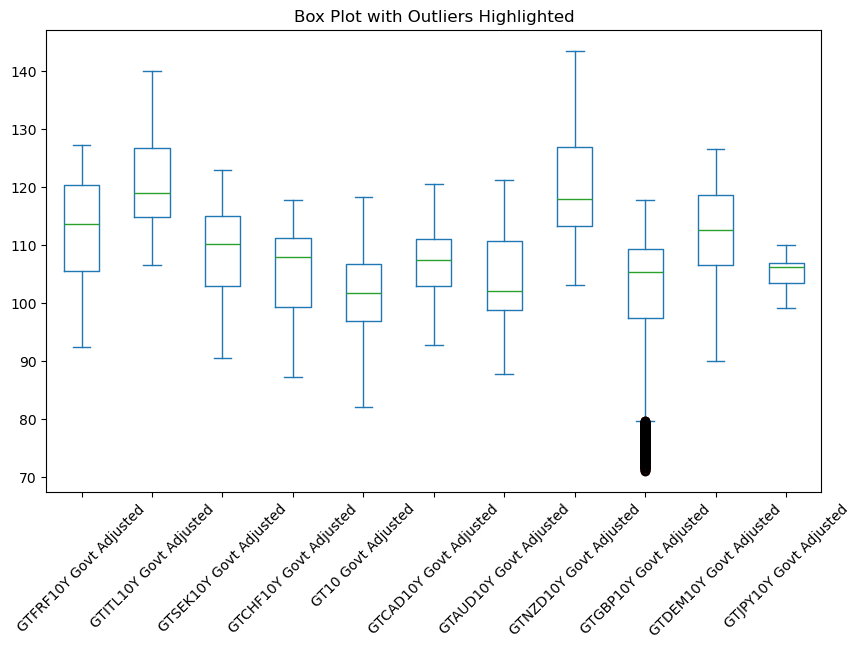

In [7]:

Q1 = tr_dm_net[col_adj_price].quantile(0.25)
Q3 = tr_dm_net[col_adj_price].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as any data point outside 1.5 * IQR from Q1 or Q3
outliers = ((tr_dm_net[col_adj_price] < (Q1 - 1.5 * IQR)) | (tr_dm_net[col_adj_price] > (Q3 + 1.5 * IQR)))

print("Outliers in the bond price data:")
for column in tr_dm_net[col_adj_price].columns:
    print(f"\nOutliers in {column}:")
    print(tr_dm_net[col_adj_price][column][outliers[column]])

plt.figure(figsize=(12, 8))
tr_dm_net[col_adj_price].plot(kind='box', figsize=(10, 6), title="Box Plot of Bond Yields with Outliers")

for column in tr_dm_net[col_adj_price].columns:
    outlier_values = tr_dm_net[col_adj_price][column][outliers[column]]
    plt.scatter(np.full(outlier_values.shape, tr_dm_net[col_adj_price].columns.get_loc(column) + 1), outlier_values, color='red', label=f'Outliers in {column}', alpha=0.6)

plt.xticks(rotation=45)
plt.title("Box Plot with Outliers Highlighted")
plt.show()

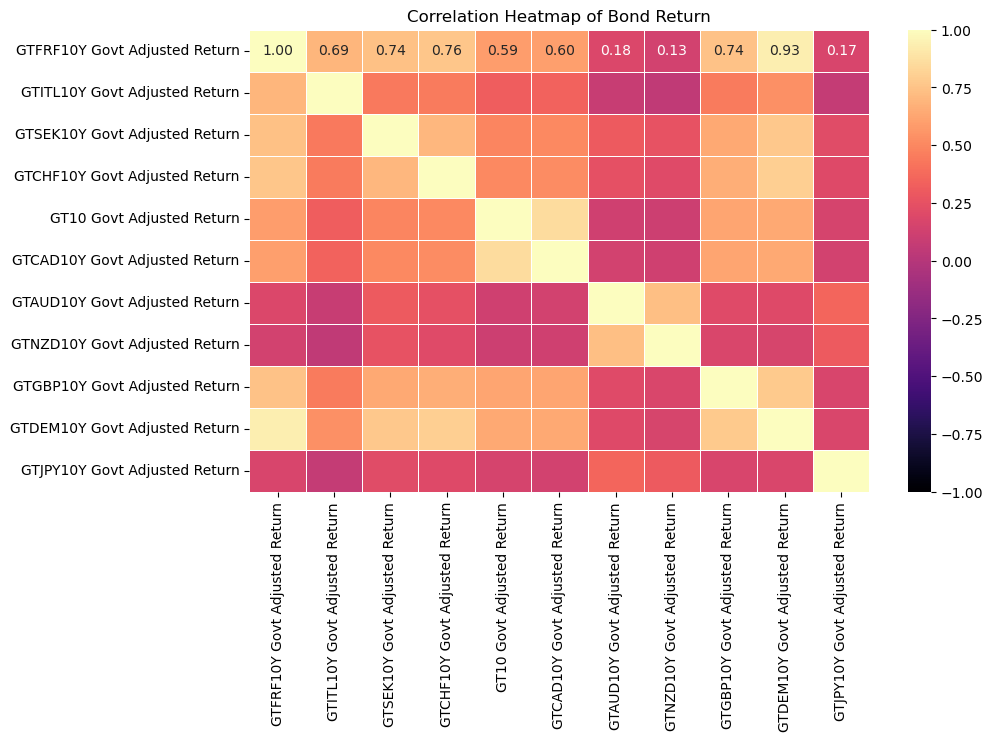

In [8]:
# Compute the regular correlation matrix on bond adjusted returns
tr_dm_return = tr_dm_net[col_adj_return]
corr_matrix = tr_dm_return.corr()
plt.figure(figsize=(10, 6))  
sns.heatmap(corr_matrix, annot=True, cmap='magma', center=0, fmt=".2f", linewidths=0.5,vmin=-1, vmax=1)

plt.title("Correlation Heatmap of Bond Return")
plt.show()


#### Plot the pairwise relationship on bond adjusted return

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

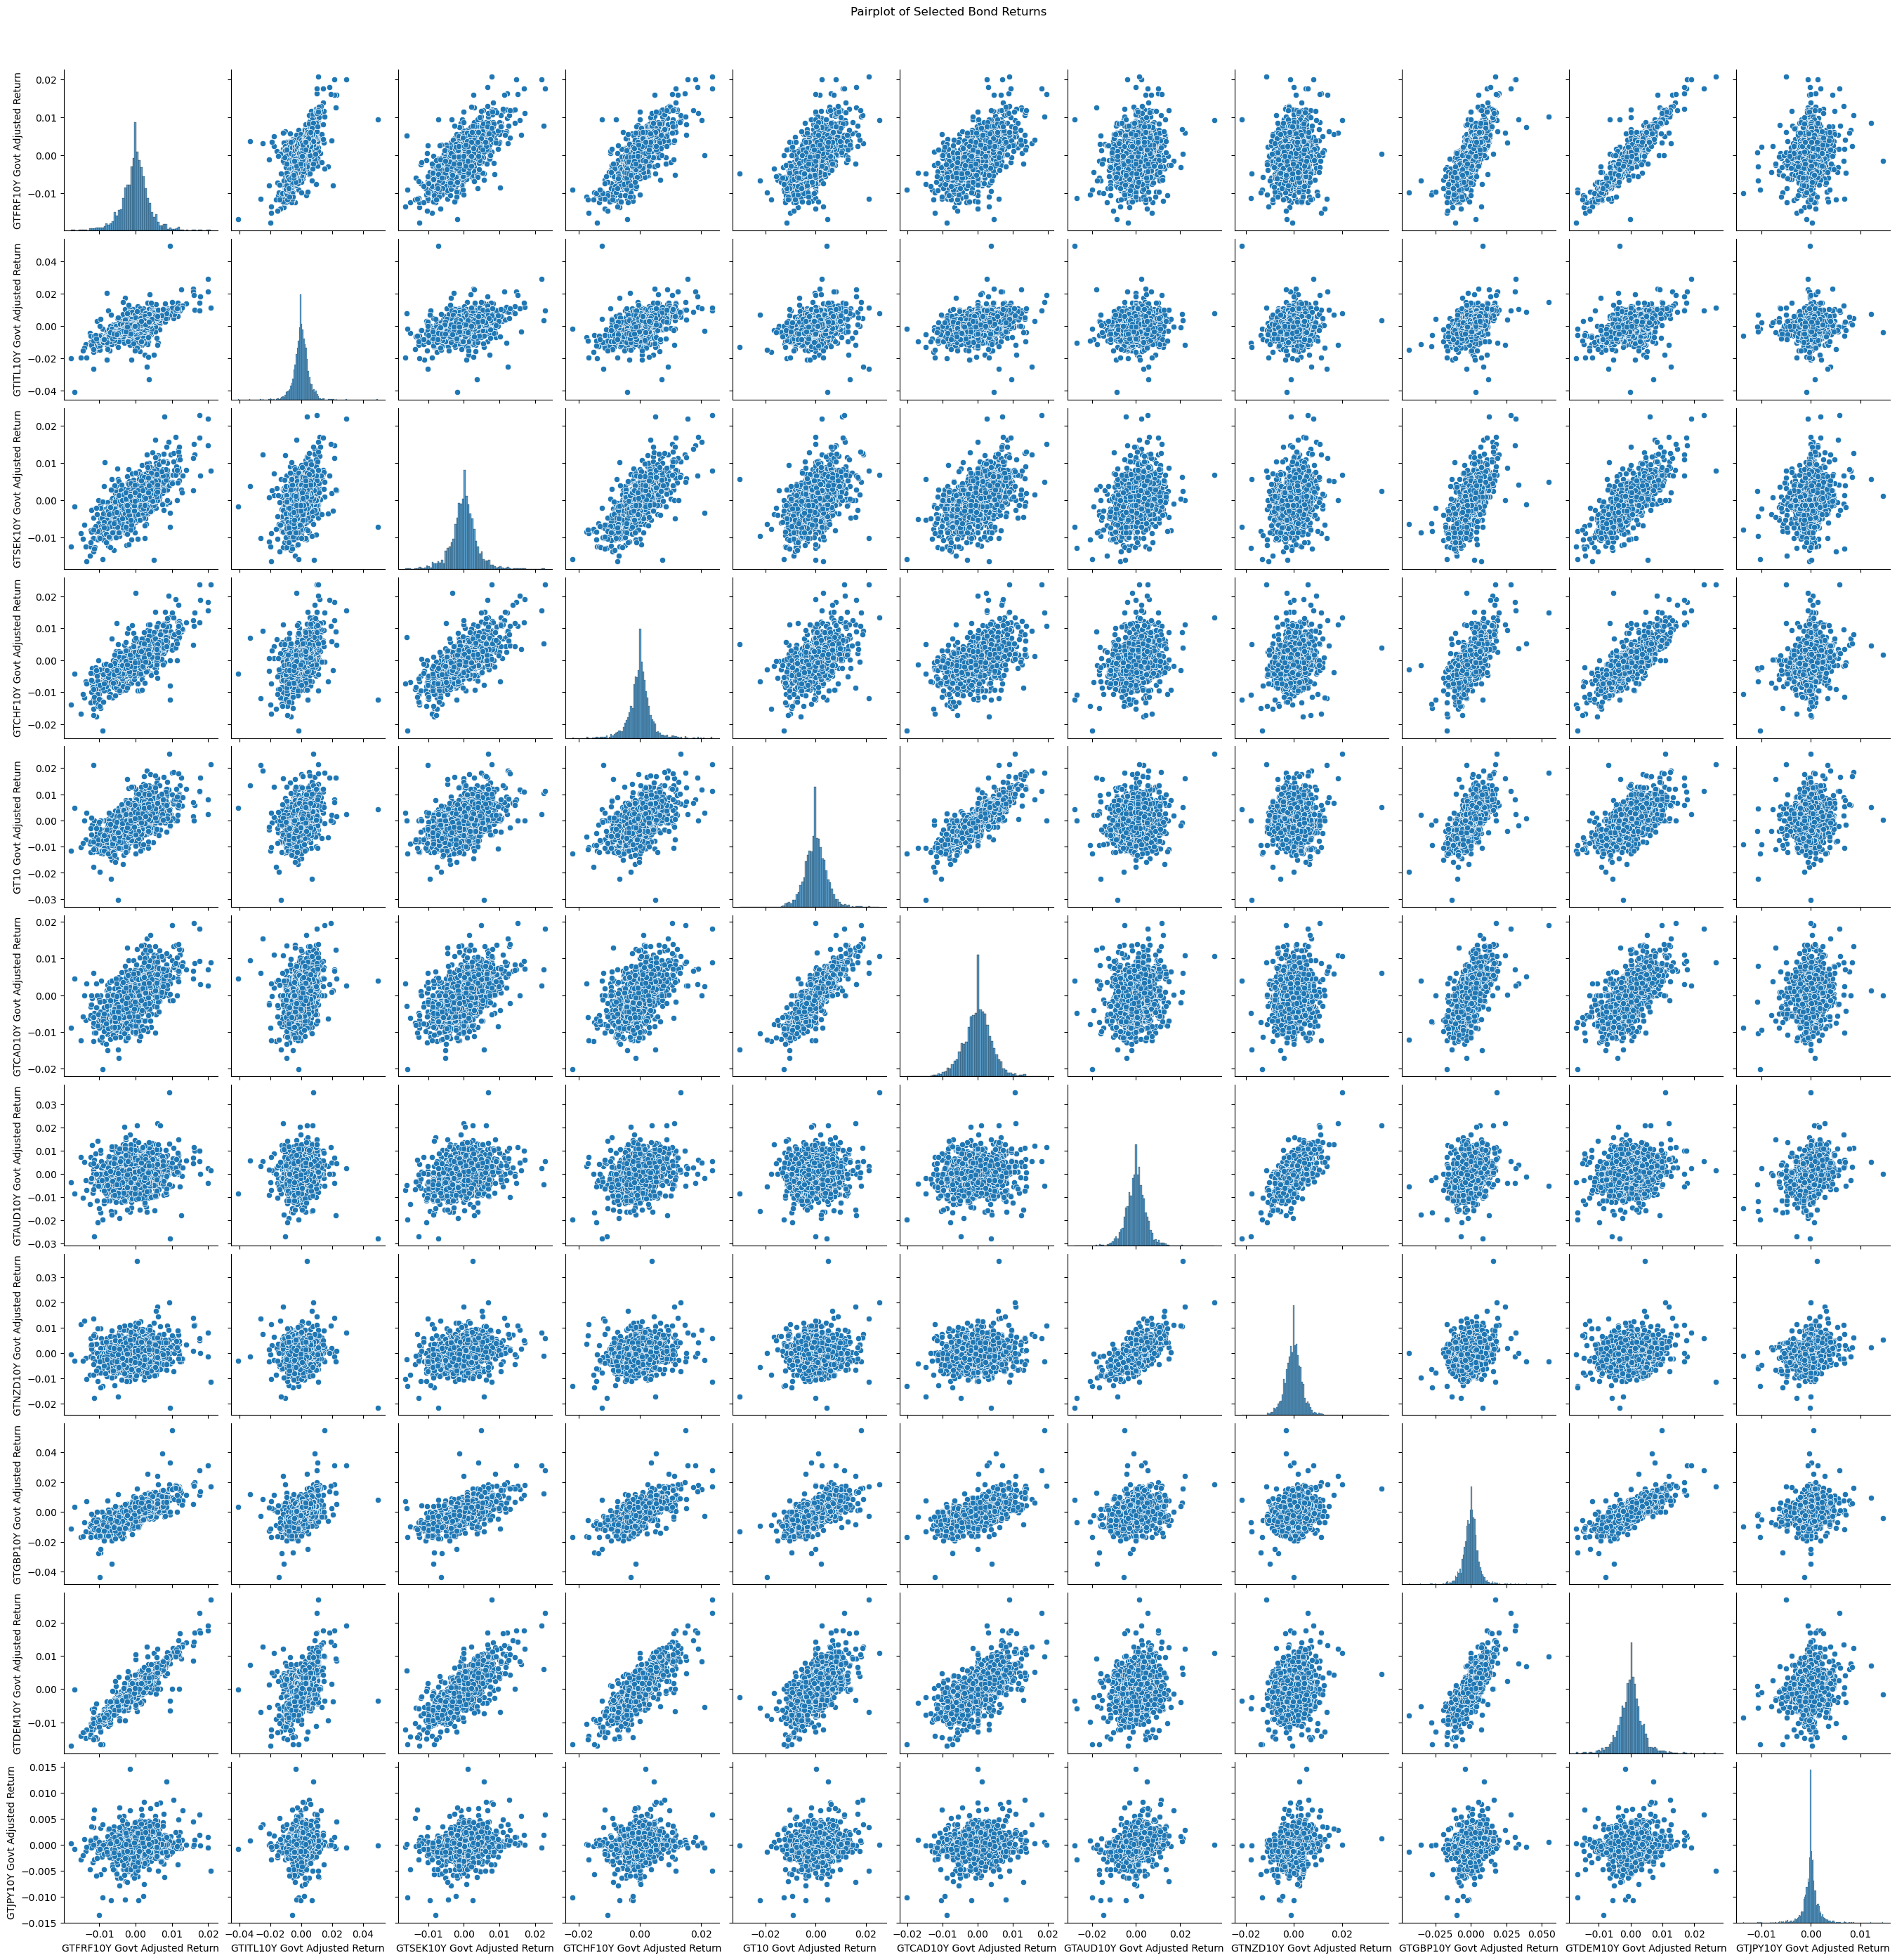

In [9]:

sns.pairplot(tr_dm_return)
plt.suptitle("Pairplot of Selected Bond Returns", y=1.02)
plt.show()

## Identify Correlated Assets (Developed Market)

### Identify a primary component (PC1) that explains most of the variance, then apply cointegration testing to find pairs that may differ in PC2 and PC3 but still move together in the long term

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

### Step1 : PCA (the first principal component)

The loadings of Bond Returns: 

                                    PC1
GTFRF10Y Govt Adjusted Return -0.387905
GTITL10Y Govt Adjusted Return -0.145706
GTSEK10Y Govt Adjusted Return -0.360855
GTCHF10Y Govt Adjusted Return -0.344324
GT10 Govt Adjusted Return     -0.320467
GTCAD10Y Govt Adjusted Return -0.328406
GTAUD10Y Govt Adjusted Return -0.157025
GTNZD10Y Govt Adjusted Return -0.140401
GTGBP10Y Govt Adjusted Return -0.375452
GTDEM10Y Govt Adjusted Return -0.405283
GTJPY10Y Govt Adjusted Return -0.139238

Explained variance of each principal component:
PC1: 0.46

Optimal number of clusters: 2


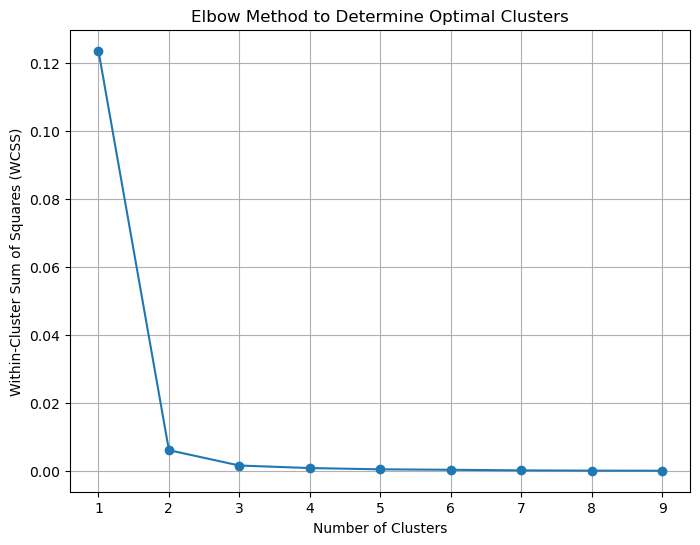


Cluster 1:
GTFRF10Y Govt Adjusted Return
GTSEK10Y Govt Adjusted Return
GTCHF10Y Govt Adjusted Return
GT10 Govt Adjusted Return
GTCAD10Y Govt Adjusted Return
GTGBP10Y Govt Adjusted Return
GTDEM10Y Govt Adjusted Return

Cluster 2:
GTITL10Y Govt Adjusted Return
GTAUD10Y Govt Adjusted Return
GTNZD10Y Govt Adjusted Return
GTJPY10Y Govt Adjusted Return


In [18]:
from sklearn.preprocessing import StandardScaler

# Project the data into the first principal components
# Standardize the data (avoid different scales to skew PCA)
asset_returns_raw = tr_dm_before_2019[col_adj_return].fillna(0)
scaler = StandardScaler()
asset_returns = pd.DataFrame(scaler.fit_transform(asset_returns_raw), columns= asset_returns_raw.columns)

# Calculate the loadings of bond returns on PCs
K = 1
pca = PCA(n_components=K)
pca.fit(asset_returns)
loadings = pca.components_.T
print('The loadings of Bond Returns: \n')
# print(pd.DataFrame(loadings, columns = ['PC1','PC2','PC3'], index = tr_dm_before_2019[col_adj_return].columns))
print(pd.DataFrame(loadings, columns = ['PC1'], index = tr_dm_before_2019[col_adj_return].columns))
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance of each principal component:")
print(f"PC1: {explained_variance[0]:.2f}") #, PC2: {explained_variance[1]:.2f}, PC3: {explained_variance[2]:.2f}")

wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(loadings)
    # Inertia: Sum of squared distances to closest cluster center
    wcss.append(kmeans.inertia_)  
    
# Use the KneeLocator to detect the elbow point
kneedle = KneeLocator(range(1, 10), wcss, S=1.0, curve='convex', direction='decreasing')

# Get the optimal number of clusters
optimal_clusters = kneedle.elbow
print(f"\nOptimal number of clusters: {optimal_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# Clustering in the principal component space and using K-means to cluster different govt bonds
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(loadings)
asset_names = asset_returns.columns

cluster_dic = {}
for cluster in range(optimal_clusters):
    print(f"\nCluster {cluster + 1}:")
    cluster_assets = asset_names[clusters == cluster]
    cluster_dic[cluster + 1] =cluster_assets
    for asset in cluster_assets:
        print(asset)

### Step 2: Scatter plot to visualize clustering results in the context of the first principal component

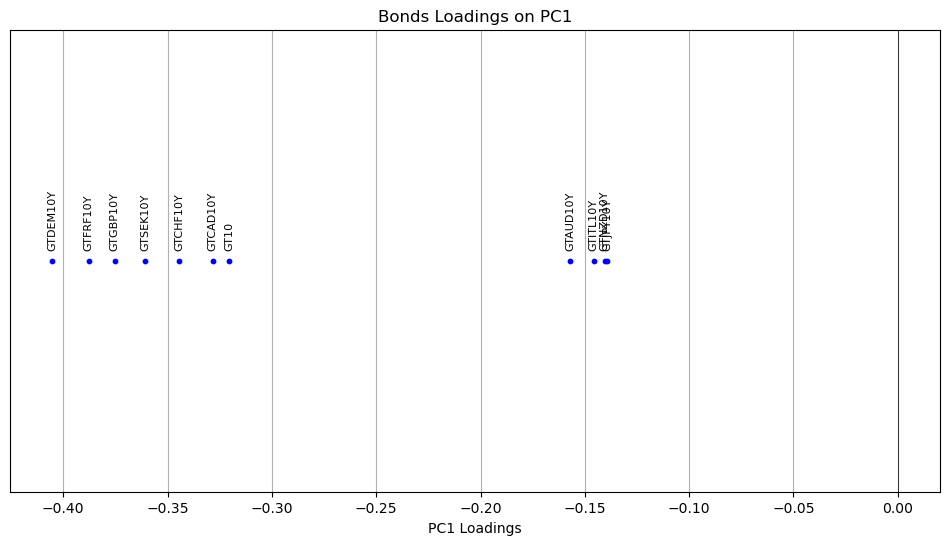

In [39]:
# Assuming `loadings` is already computed using PCA
loadings_plot = loadings.T
pc1_loadings = loadings_plot[0]  # PC1 loadings

plt.figure(figsize=(12, 6))

# Create a scatter plot of the bonds along the PC1 axis (1D plot)
y_values = [0] * len(pc1_loadings)  # All y-values are set to 0 to align them horizontally
plt.scatter(pc1_loadings, y_values, s=10, color='blue')

# Replace asset names to remove the 'Govt Adjusted Return' suffix for clarity
asset_names = [i.replace(' Govt Adjusted Return','') for i in asset_returns.columns]

# Annotate the bonds with their names along the PC1 axis
for i, bond in enumerate(asset_names):
    plt.text(pc1_loadings[i], y_values[i] + 0.003, bond, fontsize=8, ha='center', rotation=90) 


# Plot vertical line at PC1 = 0
plt.axvline(0, color='black', linewidth=0.5)

# Set axis labels and title (focus on PC1 only)
plt.xlabel('PC1 Loadings')
plt.yticks([])  # Remove y-axis labels as we are not using PC2
plt.title('Bonds Loadings on PC1')
plt.grid(True)

# Display the plot
plt.show()


### Step 3: Test cointegration relationship between pair of bond prices (after adjustment) within the same cluster

In [81]:
from statsmodels.tsa.stattools import coint

def test_cointegration_in_clusters(data, cluster_dict):

    cointegrated_pairs = []
    for cluster_num in cluster_dict:
        asset_names = cluster_dict[cluster_num]
        asset_names = [i.replace(' Return', '') for i in asset_names]
        
        print(f"\nTesting cointegration for assets in Cluster {cluster_num}:")
        
        # Loop through each pair of assets in the cluster
        for i in range(len(asset_names)):
            for j in range(i + 1, len(asset_names)):
                asset1 = asset_names[i]
                asset2 = asset_names[j]
                
                series1 = data[asset1]
                series2 = data[asset2]
                
                # Perform the Engle-Granger cointegration test
                coint_t, p_value, _ = coint(series1, series2)
                
                # set a higher significant level (0.2) to avoid missing potential relationship
                if p_value < 0.2:  
                    cointegrated_pairs.append([asset1,asset2])
                    print(f"  {asset1} and {asset2} are cointegrated (p-value: {p_value:.4f})")
                else:
                    pass
                    # print(f"  {asset1} and {asset2} are NOT cointegrated (p-value: {p_value:.4f})")

    return cointegrated_pairs

cointegrated_pairs = test_cointegration_in_clusters(tr_dm_before_2019[col_adj_price], cluster_dic)



Testing cointegration for assets in Cluster 1:

Testing cointegration for assets in Cluster 2:

Testing cointegration for assets in Cluster 3:
  GTFRF10Y Govt Adjusted and GTSEK10Y Govt Adjusted are cointegrated (p-value: 0.1275)
  GTSEK10Y Govt Adjusted and GTCHF10Y Govt Adjusted are cointegrated (p-value: 0.0990)
  GTSEK10Y Govt Adjusted and GTDEM10Y Govt Adjusted are cointegrated (p-value: 0.0541)

Testing cointegration for assets in Cluster 4:
  GTAUD10Y Govt Adjusted and GTNZD10Y Govt Adjusted are cointegrated (p-value: 0.0491)

Testing cointegration for assets in Cluster 5:


### Step 4: Exclude the pairs that have similar PC2 and PC3 loadings

In [69]:
K = 3
pca = PCA(n_components=K)
pca.fit(asset_returns)
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns = ['PC1','PC2','PC3'], index = tr_dm_before_2019[col_adj_return].columns)
print('The loadings of Bond Returns: \n')
print(loadings_df)


explained_variance = pca.explained_variance_ratio_
print("\nExplained variance of each principal component:")
print(f"PC1: {explained_variance[0]:.2f} PC2: {explained_variance[1]:.2f}, PC3: {explained_variance[2]:.2f}")


The loadings of Bond Returns: 

                                    PC1       PC2       PC3
GTFRF10Y Govt Adjusted Return -0.387905  0.092372 -0.300819
GTITL10Y Govt Adjusted Return -0.145706  0.053171 -0.745719
GTSEK10Y Govt Adjusted Return -0.360855 -0.036666 -0.118245
GTCHF10Y Govt Adjusted Return -0.344324 -0.035435 -0.061734
GT10 Govt Adjusted Return     -0.320467  0.237662  0.401941
GTCAD10Y Govt Adjusted Return -0.328406  0.205030  0.376346
GTAUD10Y Govt Adjusted Return -0.157025 -0.618510  0.070971
GTNZD10Y Govt Adjusted Return -0.140401 -0.619045  0.080513
GTGBP10Y Govt Adjusted Return -0.375452  0.084644  0.103634
GTDEM10Y Govt Adjusted Return -0.405283  0.089038 -0.081038
GTJPY10Y Govt Adjusted Return -0.139238 -0.326582  0.059994

Explained variance of each principal component:
PC1: 0.46 PC2: 0.17, PC3: 0.10


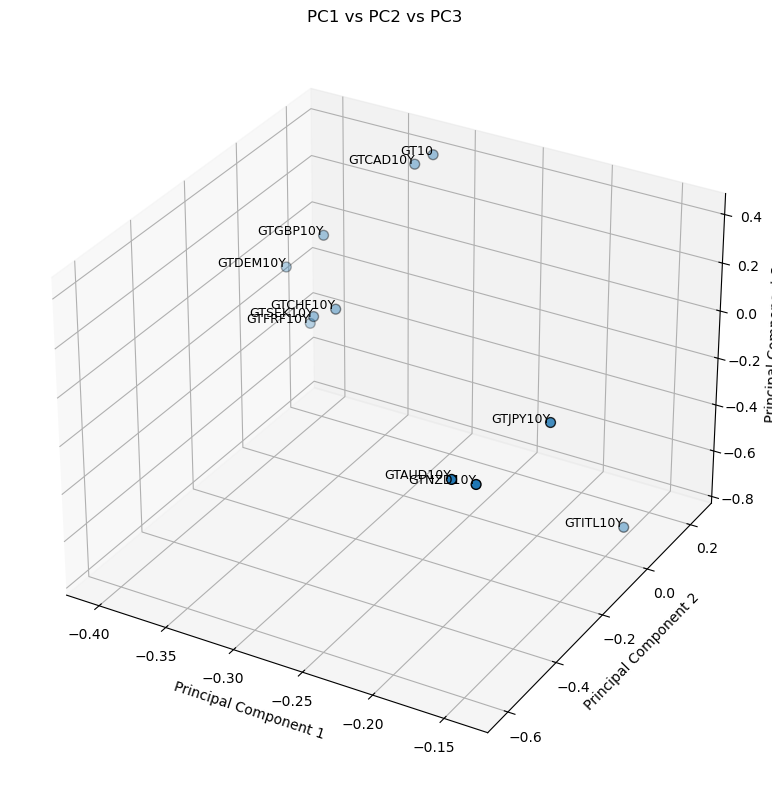

In [65]:
# Get the loadings (principal component scores) for each asset (or bond)
loadings_plot = loadings.T
pc1_loadings = loadings_plot[0]
pc2_loadings = loadings_plot[1]
pc3_loadings = loadings_plot[2]
asset_names = asset_returns.columns  

# Create the 3D scatter plot
fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(pc1_loadings, pc2_loadings, pc3_loadings, edgecolor='k', s=50)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('PC1 vs PC2 vs PC3')

asset_names = [i.replace(' Govt Adjusted Return','') for i in asset_names]
for i, bond in enumerate(asset_names):
    ax2.text(pc1_loadings[i], pc2_loadings[i], pc3_loadings[i], bond, fontsize=9, ha='right')

plt.tight_layout()
plt.show()


In [87]:
from scipy.spatial.distance import euclidean
threshold_pc2 = 0.01
threshold_pc3 = 0.01

for i in range(len(cointegrated_pairs)):
    asset1 = cointegrated_pairs[i][0]
    asset2 = cointegrated_pairs[i][1]
    
    bond1_loadings_pc2 = loadings_df.loc[f"{asset1} Return", 'PC2'] 
    bond2_loadings_pc2 = loadings_df.loc[f"{asset2} Return", 'PC2'] 
    
    bond1_loadings_pc3 = loadings_df.loc[f"{asset1} Return", 'PC3']
    bond2_loadings_pc3 = loadings_df.loc[f"{asset2} Return", 'PC3']  
    
    # Euclidean distance between PC2 and PC3 loadings
    distance_pc2 = euclidean([bond1_loadings_pc2], [bond2_loadings_pc2])
    distance_pc3 = euclidean([bond1_loadings_pc3], [bond2_loadings_pc3])
    
    if distance_pc2 > threshold_pc2 and distance_pc3 > threshold_pc3:
        print(f"Bond pair ({asset1}, {asset2}) can be used for pair trading.")
    else:
        print(f"Bond pair ({asset1}, {asset2}) can NOT be used for pair trading.")

Bond pair (GTFRF10Y Govt Adjusted, GTSEK10Y Govt Adjusted) can be used for pair trading.
Bond pair (GTSEK10Y Govt Adjusted, GTCHF10Y Govt Adjusted) can NOT be used for pair trading.
Bond pair (GTSEK10Y Govt Adjusted, GTDEM10Y Govt Adjusted) can be used for pair trading.
Bond pair (GTAUD10Y Govt Adjusted, GTNZD10Y Govt Adjusted) can NOT be used for pair trading.
